In [41]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [42]:
dataset = 'hand_landmarks_end.csv'
#model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
#tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
model_save_path = 'new_hand_classifier.hdf5'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [32]:
NUM_CLASSES = 26

# Dataset reading

In [33]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [34]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [37]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 21, 2, 1)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640)              

In [38]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [39]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [40]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
28/29 [===========================>..] - ETA: 0s - loss: 3.0011 - accuracy: 0.1189
Epoch 1: saving model to new_hand_classifier.hdf5
29/29 [==============================] - 1s 15ms/step - loss: 2.9996 - accuracy: 0.1186 - val_loss: 2.5307 - val_accuracy: 0.1975
Epoch 2/1000
27/29 [==========================>...] - ETA: 0s - loss: 2.2688 - accuracy: 0.2703

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to new_hand_classifier.hdf5
29/29 [==============================] - 0s 9ms/step - loss: 2.2527 - accuracy: 0.2756 - val_loss: 1.6739 - val_accuracy: 0.4550
Epoch 3/1000
28/29 [===========================>..] - ETA: 0s - loss: 1.6262 - accuracy: 0.4453
Epoch 3: saving model to new_hand_classifier.hdf5
29/29 [==============================] - 0s 9ms/step - loss: 1.6232 - accuracy: 0.4464 - val_loss: 1.0220 - val_accuracy: 0.7358
Epoch 4/1000
26/29 [=========================>....] - ETA: 0s - loss: 1.1431 - accuracy: 0.6019
Epoch 4: saving model to new_hand_classifier.hdf5
29/29 [==============================] - 0s 9ms/step - loss: 1.1262 - accuracy: 0.6081 - val_loss: 0.6455 - val_accuracy: 0.8000
Epoch 5/1000
23/29 [======================>.......] - ETA: 0s - loss: 0.8190 - accuracy: 0.7140
Epoch 5: saving model to new_hand_classifier.hdf5
29/29 [==============================] - 0s 9ms/step - loss: 0.8030 - accuracy: 0.7219 - val_loss: 0.4143 - val_accuracy: 0.

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 5ms/step - loss: 5.1535e-06 - accuracy: 1.0000


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 129ms/step
[4.7463160e-18 5.3960650e-07 5.0120379e-18 1.4934461e-14 4.0169468e-09
 1.8996792e-10 1.7155002e-14 4.0754378e-20 2.2137455e-12 1.2064293e-15
 1.8200367e-06 6.3899401e-13 1.1116866e-14 6.4796817e-13 3.4949393e-17
 3.0985878e-18 1.2463770e-18 9.9999702e-01 5.7738714e-07 3.4294144e-13
 1.5486944e-09 4.9110954e-10 1.7519659e-11 3.4759264e-17 1.2975103e-19
 3.2912154e-18]
17


# Confusion matrix

19/19 [==============================] - 0s 2ms/step


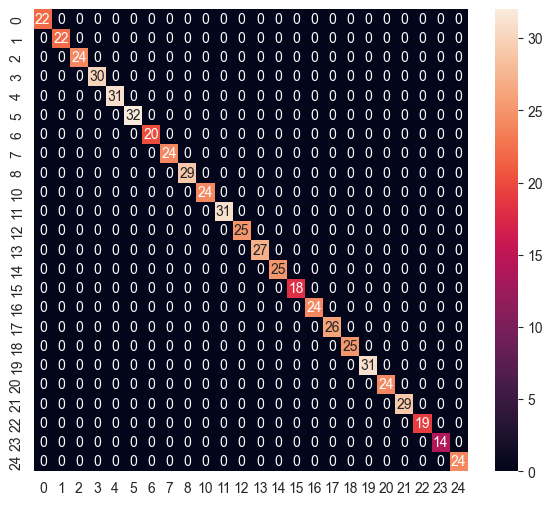

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        32
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        29
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        31
          12       1.00      1.00      1.00        25
          13       1.00      1.00      1.00        27
          14       1.00      1.00      1.00        25
          15       1.00      1.00      1.00        18
          16       1.00      1.00      1.00        24
          17       1.00      1.00      1.00        26
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp98p_v72g\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp98p_v72g\assets


105472

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 10 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.84156272e-18 6.17081355e-07 5.81439521e-18 1.59972912e-14
 4.79930762e-09 2.51102195e-10 1.92256963e-14 4.64494613e-20
 2.56319813e-12 1.58216490e-15 2.11020779e-06 6.88853705e-13
 1.28763916e-14 7.34943031e-13 4.37910442e-17 3.72599247e-18
 1.57703462e-18 9.99996662e-01 6.31938576e-07 4.44213107e-13
 1.67700820e-09 5.98561645e-10 1.84981943e-11 4.64936749e-17
 1.56542406e-19 3.45851679e-18]
17


In [27]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmppyv63bhp\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmppyv63bhp\assets


#### Loss  (cost)

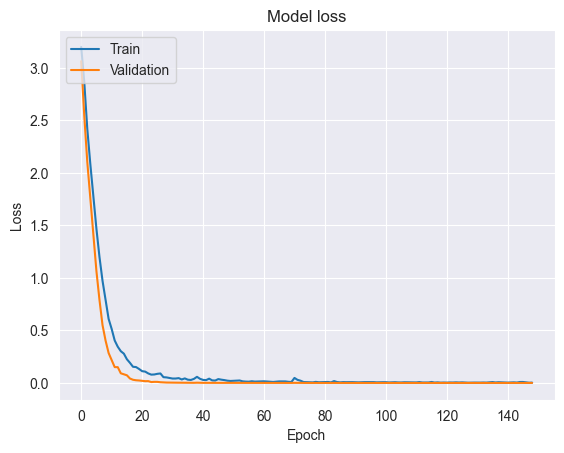

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

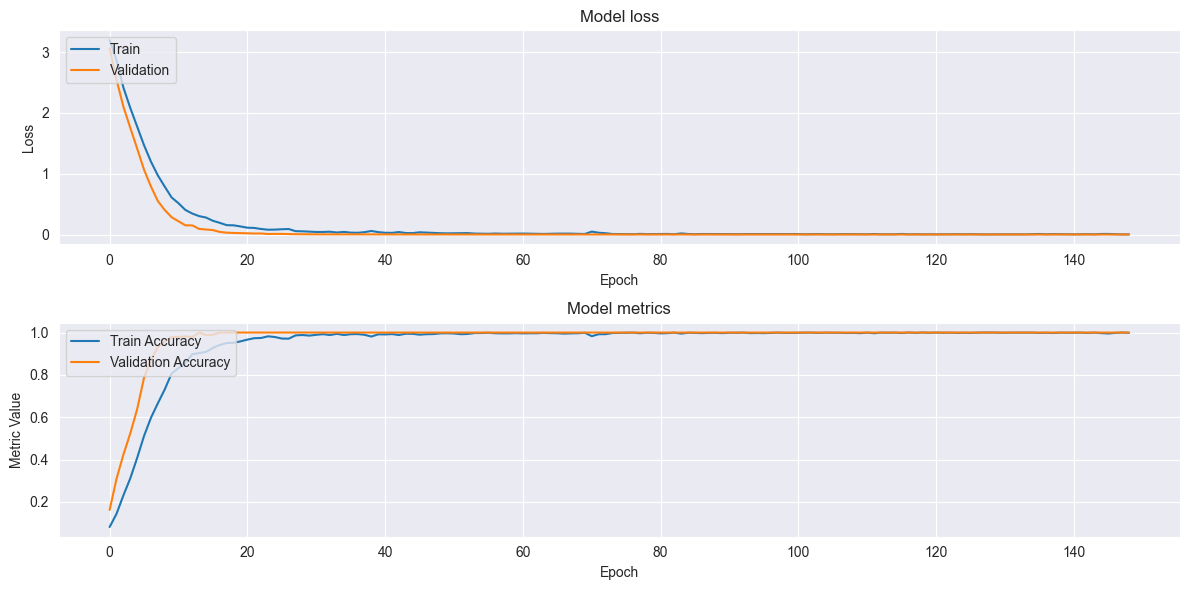

In [25]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

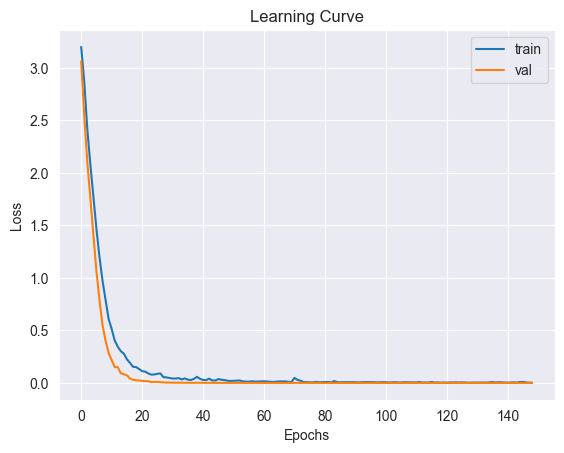

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()